In [ ]:
import pandas as pd
import numpy as np
import re, os
from string import printable
from sklearn import model_selection
from sklearn.model_selection import train_test_split
#import gensim
import tensorflow as tf
from keras.models import Sequential, Model, model_from_json, load_model
from keras import regularizers
from keras.layers import Dense, Dropout, Activation, Lambda, Flatten
from keras.layers import Input, ELU, LSTM, Embedding, Convolution2D, MaxPooling2D, BatchNormalization, Convolution1D, MaxPooling1D, concatenate
from keras.preprocessing import sequence
from keras.optimizers import SGD, Adam, RMSprop
# from keras.utils import np_utils  # This line is removed
from keras import backend as K
from tensorflow.keras.utils import to_categorical # Use this for one-hot encoding

from pathlib import Path
import json

import warnings
warnings.filterwarnings("ignore")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
## Load data URL
import io
df = pd.read_csv('/content/drive/MyDrive/dataset.csv')


In [ ]:
# Initial Data Preparation URL

# Step 1: Convert raw URL string in list of lists where characters that are contained in "printable" are stored encoded as integer
url_int_tokens = [[printable.index(x) + 1 for x in url if x in printable] for url in df.url]

# Step 2: Cut URL string at max_len or pad with zeros if shorter
max_len=75
X = sequence.pad_sequences(url_int_tokens, maxlen=max_len)

# Step 3: Extract labels form df to numpy array
y = np.array(df.isMalicious)

print('Matrix dimensions of X: ', X.shape, 'Vector dimension of target: ', y.shape)


Matrix dimensions of X:  (194798, 75) Vector dimension of target:  (194798,)


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.layers import BatchNormalization, Dropout, SpatialDropout1D

def cnn_bilstm_model(input_shape, vocab_size):
    input_layer = layers.Input(shape=(input_shape,))

    # Embedding layer with Spatial Dropout
    embedding = layers.Embedding(input_dim=vocab_size, output_dim=128)(input_layer)
    embedding = SpatialDropout1D(0.3)(embedding)

    # CNN layers with 'same' padding
    cnn_out_1 = layers.Conv1D(filters=256, kernel_size=4, activation='relu', padding='same')(embedding)
    cnn_out_2 = layers.Conv1D(filters=256, kernel_size=5, activation='relu', padding='same')(embedding)
    cnn_out_3 = layers.Conv1D(filters=256, kernel_size=6, activation='relu', padding='same')(embedding)

    # Concatenate the CNN outputs
    cnn_out = layers.concatenate([cnn_out_1, cnn_out_2, cnn_out_3])

    # Instead of GlobalMaxPooling1D, apply BatchNormalization and Dropout directly to the CNN output:
    cnn_out = BatchNormalization()(cnn_out)
    cnn_out = Dropout(0.3)(cnn_out)  # Increased dropout for better regularization

    # Reshape CNN output to match LSTM input shape
    cnn_out = layers.Reshape((cnn_out.shape[1], cnn_out.shape[2]))(cnn_out)

    # BiLSTM layer (increased units)
    lstm_out = layers.Bidirectional(layers.LSTM(128, return_sequences=True))(cnn_out)  # Increased units, return_sequences=True for stacked LSTMs
    lstm_out = layers.Bidirectional(layers.LSTM(64))(lstm_out)  # Added another BiLSTM layer
    lstm_out = BatchNormalization()(lstm_out)
    lstm_out = Dropout(0.4)(lstm_out)  # Higher dropout in LSTM layers

    # Output layer
    output_layer = layers.Dense(1, activation='sigmoid')(lstm_out)

    # Build the model
    model = Model(inputs=input_layer, outputs=output_layer)

    return model

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [ ]:
def create_tasks(X, y, num_tasks, task_size):
    tasks = []
    for _ in range(num_tasks):
        indices = np.random.choice(len(X), size=task_size, replace=False)
        tasks.append((X[indices], y[indices]))
    return tasks



In [ ]:
tasks = create_tasks(X_train, y_train, num_tasks=10, task_size=100)


In [ ]:
def reptile_train(model, tasks, num_iterations=10, inner_steps=3, outer_steps=3):
    # Get the model's initial weights
    initial_weights = model.get_weights()

    for iteration in range(num_iterations):
        # Sample task indices for this iteration
        selected_task_indices = np.random.choice(len(tasks), size=outer_steps, replace=False)
        selected_tasks = [tasks[i] for i in selected_task_indices]

        # Store the updated weights for each task
        updated_weights = []

        for task in selected_tasks:
            X_task, y_task = task
            task_model = model  # Use the same model for tasks
            task_model.set_weights(initial_weights)  # Reset model to initial weights

            # Train the model on the task
            task_model.fit(X_task, y_task, epochs=inner_steps, verbose=0)

            # Retrieve the updated weights as numpy arrays
            updated_weights.append([np.array(w) for w in task_model.get_weights()])

        # Ensure consistency in weight shapes
        first_weight_shapes = [w.shape for w in updated_weights[0]]
        consistent_shapes = all(
            all(w1.shape == w2.shape for w1, w2 in zip(task_weights, updated_weights[0]))
            for task_weights in updated_weights
        )

        if consistent_shapes:
            # Average the weights from the tasks
            average_weights = [
                np.mean([task_weights[i] for task_weights in updated_weights], axis=0)
                for i in range(len(updated_weights[0]))
            ]
            # Set the model weights to the averaged weights
            model.set_weights(average_weights)
        else:
            print("Warning: Inconsistent weight shapes detected, skipping averaging for this iteration.")

        print(f'Iteration {iteration + 1}/{num_iterations} completed.')



In [ ]:
# Assuming you have your data prepared as X and y
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create tasks for meta-learning
tasks = create_tasks(X_train, y_train, num_tasks=10, task_size=100)

# Initialize the CNN-BiLSTM model
model = cnn_bilstm_model(input_shape=X_train.shape[1], vocab_size=len(printable))

# Compile the model before training
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model using the meta-learning approach
reptile_train(model, tasks, inner_steps=20)

# Evaluate on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f'Test Loss: {test_loss}, Test Accuracy: {test_accuracy}')


Iteration 1/10 completed.
Iteration 2/10 completed.
Iteration 3/10 completed.
Iteration 4/10 completed.
Iteration 5/10 completed.
Iteration 6/10 completed.
Iteration 7/10 completed.
Iteration 8/10 completed.
Iteration 9/10 completed.
Iteration 10/10 completed.
1218/1218 [==============================] - 67s 54ms/step - loss: 0.6628 - accuracy: 0.6335
Test Loss: 0.6627674102783203, Test Accuracy: 0.6334702372550964


In [ ]:
!pip install keras-tuner


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 2.7 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from kerastuner import HyperModel, RandomSearch
from sklearn.model_selection import train_test_split

# Assuming you have your data prepared as X and y
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# HyperModel definition
class MyHyperModel(HyperModel):
    def build(self, hp):
        model = cnn_bilstm_model(input_shape=X_train.shape[1], vocab_size=len(printable))
        model.compile(
            optimizer=tf.keras.optimizers.Adam(
                learning_rate=hp.Float('learning_rate', min_value=1e-5, max_value=1e-3, sampling='LOG')
            ),
            loss='binary_crossentropy',
            metrics=['accuracy']
        )
        return model

# Custom callback to save training history
class HistorySaver(tf.keras.callbacks.Callback):
    def __init__(self, save_path, trial_id):
        super().__init__()
        self.save_path = save_path
        self.trial_id = trial_id
        self.history_logs = []

    def on_epoch_end(self, epoch, logs=None):
        if logs:
            logs = {
                'epoch': epoch,
                'accuracy': logs.get('accuracy', None),
                'loss': logs.get('loss', None),
                'val_accuracy': logs.get('val_accuracy', None),
                'val_loss': logs.get('val_loss', None)
            }
            self.history_logs.append(logs)

    def on_train_end(self, logs=None):
        if self.history_logs:
            history_df = pd.DataFrame(self.history_logs)
            history_df.to_csv(f"{self.save_path}/trial_{self.trial_id}_history.csv", index=False)
        else:
            print("No training history recorded.")

# Function to perform hyperparameter tuning with Reptile training
def perform_hyperparameter_tuning(X_train, y_train, num_tasks=10, task_size=100):
    save_path = '/content/drive/My Drive/tuner_results'

    # Create tasks for meta-learning
    tasks = create_tasks(X_train, y_train, num_tasks=num_tasks, task_size=task_size)

    # Initialize the hypermodel and tuner
    hypermodel = MyHyperModel()
    tuner = RandomSearch(
        hypermodel,
        objective='val_accuracy',
        max_trials=1,  # Set to 1 for only one trial
        executions_per_trial=1,
        directory=save_path,
        project_name='reptile_tuning'
    )

    # Perform hyperparameter search and save each trial’s history
    tuner.search(X_train, y_train, epochs=20, validation_data=(X_test, y_test), batch_size=32)

    # Retrieve the best trial and corresponding model
    best_trial = tuner.oracle.get_best_trials(num_trials=1)[0]
    hp = best_trial.hyperparameters
    best_model = hypermodel.build(hp)

    # Initialize the history saver for the best trial
    history_saver = HistorySaver(save_path, trial_id="best")

    # Train the best model
    best_model.fit(X_train, y_train, epochs=20, verbose=0, callbacks=[history_saver])
    reptile_train(best_model, tasks, inner_steps=3)

    # Save the model history for the best trial
    history_saver.on_train_end()

    # Save only the best model
    best_model.save('/content/drive/My Drive/tuner_results/bestmodel.h5')
    print("Best model saved successfully as bestmodel.h5.")

# Run the hyperparameter tuning
perform_hyperparameter_tuning(X_train, y_train)



Trial 1 Complete [04h 25m 08s]
val_accuracy: 0.9757956862449646

Best val_accuracy So Far: 0.9757956862449646
Total elapsed time: 04h 25m 08s
Iteration 1/10 completed.
Iteration 2/10 completed.
Iteration 3/10 completed.
Iteration 4/10 completed.
Iteration 5/10 completed.
Iteration 6/10 completed.
Iteration 7/10 completed.
Iteration 8/10 completed.
Iteration 9/10 completed.
Iteration 10/10 completed.
Best model saved successfully as bestmodel.h5.


In [ ]:
# Evaluate on the test set
test_loss, test_accuracy = best_model.evaluate(X_test, y_test)
print(f'Test Loss: {test_loss}, Test Accuracy: {test_accuracy}')

1218/1218 [==============================] - 67s 54ms/step - loss: 0.0874 - accuracy: 0.9750
Test Loss: 0.08742957562208176, Test Accuracy: 0.9749743342399597


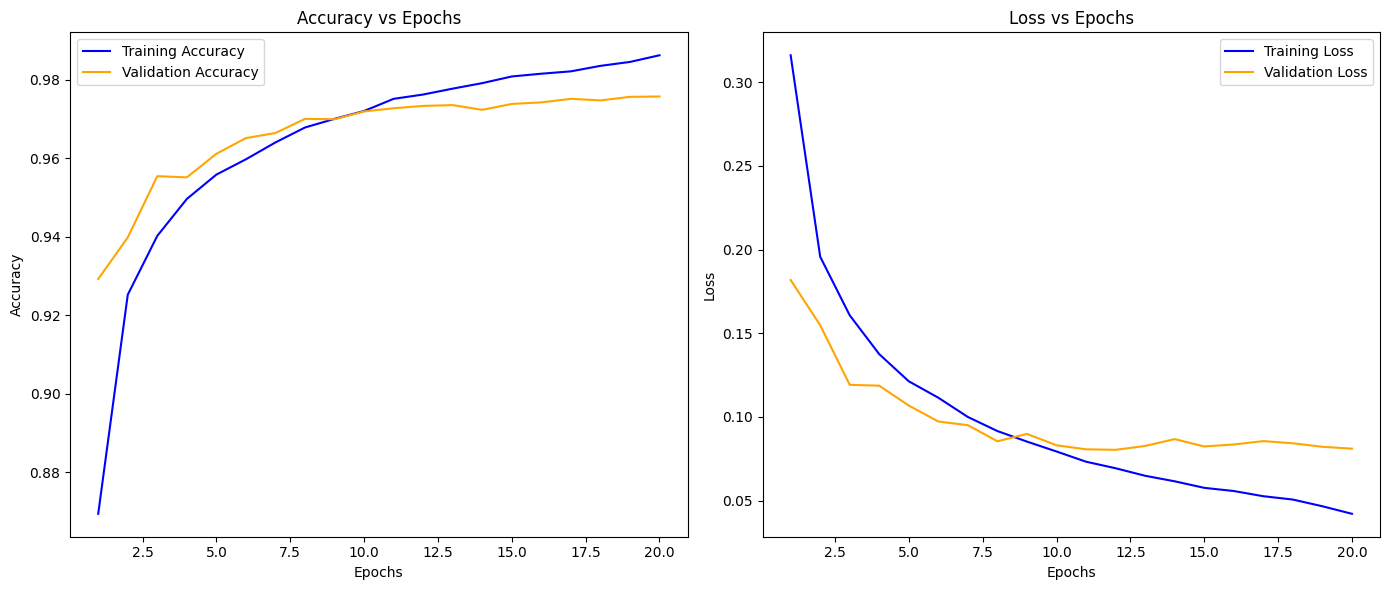

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the CSV file (replace with your Google Drive path if needed)
data = pd.read_csv('/content/drive/MyDrive/tuner_results/history.csv')

# Create a subplot with 1 row and 2 columns
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Plot Accuracy and Validation Accuracy
ax1.plot(data['Epoch'], data['Training Accuracy'], label='Training Accuracy', color='blue')
ax1.plot(data['Epoch'], data['Validation Accuracy'], label='Validation Accuracy', color='orange')
ax1.set_title('Accuracy vs Epochs')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Accuracy')
ax1.legend()

# Plot Loss and Validation Loss
ax2.plot(data['Epoch'], data['Training Loss'], label='Training Loss', color='blue')
ax2.plot(data['Epoch'], data['Validation Loss'], label='Validation Loss', color='orange')
ax2.set_title('Loss vs Epochs')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Loss')
ax2.legend()

# Display the plot
plt.tight_layout()
plt.show()


In [ ]:
from tensorflow.keras.models import load_model

# Load the best model
best_model = load_model('/content/drive/MyDrive/tuner_results/bestmodel.h5')

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Predict on the test set using the trained best model
y_pred = (best_model.predict(X_test) > 0.5).astype(int)

# Calculate precision, recall, and F1-score
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Print the results
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1-score: {f1:.4f}')


1218/1218 [==============================] - 67s 54ms/step
Precision: 0.9780
Recall: 0.9717
F1-score: 0.9749


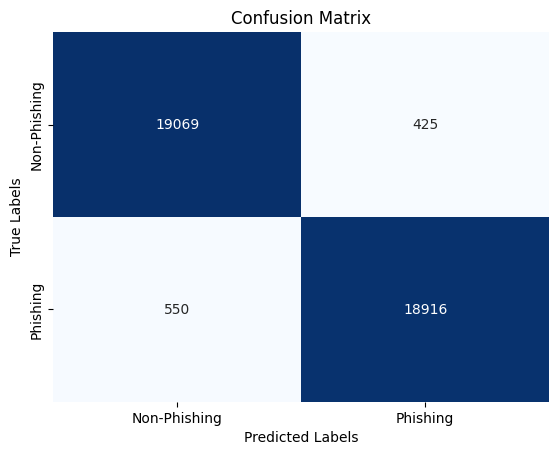

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix using seaborn heatmap
#plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False, xticklabels=['Non-Phishing', 'Phishing'], yticklabels=['Non-Phishing', 'Phishing'])
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()


In [ ]:
target_proba = best_model.predict(X_test, batch_size=1)

38960/38960 [==============================] - 558s 14ms/step


In [ ]:
def print_result(proba):
    if proba > 0.5:
        return "Phishing website"
    else:
        return "Legitimate website"

**TESTING**

In [ ]:

url = "https://tkmce.ac.in/ug-programmes"

# Step 1: Convert raw URL string in list of lists where characters that are contained in "printable" are stored encoded as integer
url_int_tokens = [[printable.index(x) + 1 for x in url if x in printable]]

# Step 2: Cut URL string at max_len or pad with zeros if shorter
max_len=75
X = sequence.pad_sequences(url_int_tokens, maxlen=max_len)
probab=best_model.predict(X,batch_size=1)
print(print_result(probab))

1/1 [==============================] - 0s 40ms/step
Legitimate website


In [ ]:

url = "http://bankofamerica-security-alert.com/login"
# Step 1: Convert raw URL string in list of lists where characters that are contained in "printable" are stored encoded as integer
url_int_tokens = [[printable.index(x) + 1 for x in url if x in printable]]

# Step 2: Cut URL string at max_len or pad with zeros if shorter
max_len=75
X = sequence.pad_sequences(url_int_tokens, maxlen=max_len)
probab=best_model.predict(X,batch_size=1)
print(print_result(probab))

1/1 [==============================] - 0s 39ms/step
Phishing website


In [ ]:
url = "https://help.emailoctopus.com/article/185-integrating-with-carrd"
# Step 1: Convert raw URL string in list of lists where characters that are contained in "printable" are stored encoded as integer
url_int_tokens = [[printable.index(x) + 1 for x in url if x in printable]]

# Step 2: Cut URL string at max_len or pad with zeros if shorter
max_len=75
X = sequence.pad_sequences(url_int_tokens, maxlen=max_len)
probab=best_model.predict(X,batch_size=1)
print(print_result(probab))

1/1 [==============================] - 0s 37ms/step
Legitimate website


In [ ]:
url = "kellyscleaningservice.com.au/wp-admin/maint/gmail"
# Step 1: Convert raw URL string in list of lists where characters that are contained in "printable" are stored encoded as integer
url_int_tokens = [[printable.index(x) + 1 for x in url if x in printable]]

# Step 2: Cut URL string at max_len or pad with zeros if shorter
max_len=75
X = sequence.pad_sequences(url_int_tokens, maxlen=max_len)
probab=best_model.predict(X,batch_size=1)
print(print_result(probab))

1/1 [==============================] - 0s 38ms/step
Phishing website


In [ ]:
import tensorflow as tf

# Load the best model from Google Drive
model_path = '/content/drive/MyDrive/tuner_results/bestmodel.h5'
best_model = tf.keras.models.load_model(model_path)

# Confirm the model is loaded
best_model.summary()


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 75)]                 0         []                            
                                                                                                  
 embedding_1 (Embedding)     (None, 75, 128)              12800     ['input_2[0][0]']             
                                                                                                  
 spatial_dropout1d_1 (Spati  (None, 75, 128)              0         ['embedding_1[0][0]']         
 alDropout1D)                                                                                     
                                                                                                  
 conv1d_3 (Conv1D)           (None, 75, 256)              131328    ['spatial_dropout1d_1[0]